<a href="https://colab.research.google.com/github/luizgonzagasilva/kaggle-wids2022/blob/main/SerieTemporal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download conjunto de dados

In [1]:
!pip install kaggle

!mkdir .kaggle
!touch .kaggle/kaggle.json

api_token = {"username":"luizgonzagajunior","key":"374402bd0762f08f49a322b975e8c89f"}

import json
import zipfile
import os
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /content/.kaggle/kaggle.json

In [2]:
!rm /root/.kaggle/kaggle.json -f

In [3]:
!mv .kaggle /root/
!chmod 600 /root/.kaggle/kaggle.json
!cat /root/.kaggle/kaggle.json

{"username": "luizgonzagajunior", "key": "374402bd0762f08f49a322b975e8c89f"}

In [4]:
!kaggle competitions download -c widsdatathon2022

  0% 0.00/1.65M [00:00<?, ?B/s]
100% 1.65M/1.65M [00:00<00:00, 56.2MB/s]
  0% 0.00/157k [00:00<?, ?B/s]
100% 157k/157k [00:00<00:00, 138MB/s]
  0% 0.00/94.8k [00:00<?, ?B/s]
100% 94.8k/94.8k [00:00<00:00, 100MB/s]


In [5]:
! ls -l

total 1948
drwxr-xr-x 1 root root    4096 Feb 18 14:33 sample_data
-rw-r--r-- 1 root root   97062 Feb 26 11:20 sample_solution.csv
-rw-r--r-- 1 root root  160497 Feb 26 11:20 test.csv.zip
-rw-r--r-- 1 root root 1726416 Feb 26 11:20 train.csv.zip


# Exploração

In [6]:
import pandas as pd
df = pd.read_csv('train.csv.zip')
df.shape

(75757, 64)

In [7]:
df.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4


In [57]:
df['State_Factor'].value_counts()

State_11    6412
State_1     5618
State_2     4871
State_4     4300
State_8     3701
State_10      15
Name: State_Factor, dtype: int64

In [56]:
df = df[df['State_Factor']!='State_6']

In [9]:
df['building_class'].value_counts()

Residential    43558
Commercial     32199
Name: building_class, dtype: int64

In [10]:
df['facility_type'] = df['facility_type'].apply(lambda x: x.split('_')[0])
df['facility_type'].value_counts()

Multifamily    39455
Office         13150
Education       5733
Warehouse       2879
Lodging         2847
2to4            1893
Commercial      1839
Retail          1437
5plus           1273
Public           990
Mixed            937
Nursing          772
Health           552
Grocery          448
Religious        399
Industrial       384
Parking          251
Service          215
Food             169
Laboratory       107
Data              27
Name: facility_type, dtype: int64

In [11]:
df['Year_Factor'].value_counts()

6    22449
5    18308
4    12946
3    10879
2     9058
1     2117
Name: Year_Factor, dtype: int64

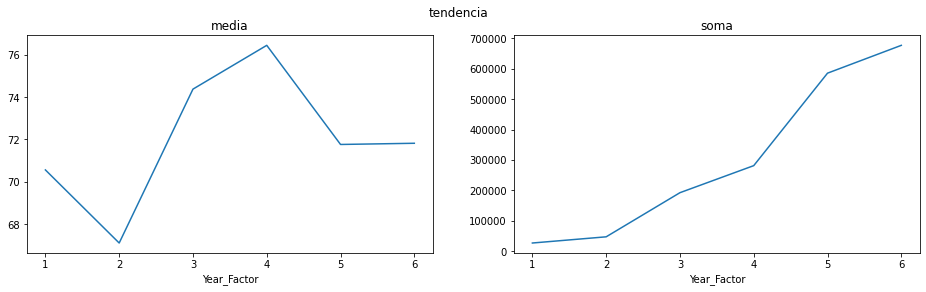

In [58]:
import matplotlib.pyplot as plt
grp = df.groupby(by='Year_Factor')
fig, (ax1,ax2) = plt.subplots(1,2, figsize=[16,4])
fig.suptitle('tendencia')
grp['site_eui'].mean().plot(ax=ax1, title='media')
grp['site_eui'].sum().plot(ax=ax2, title='soma')

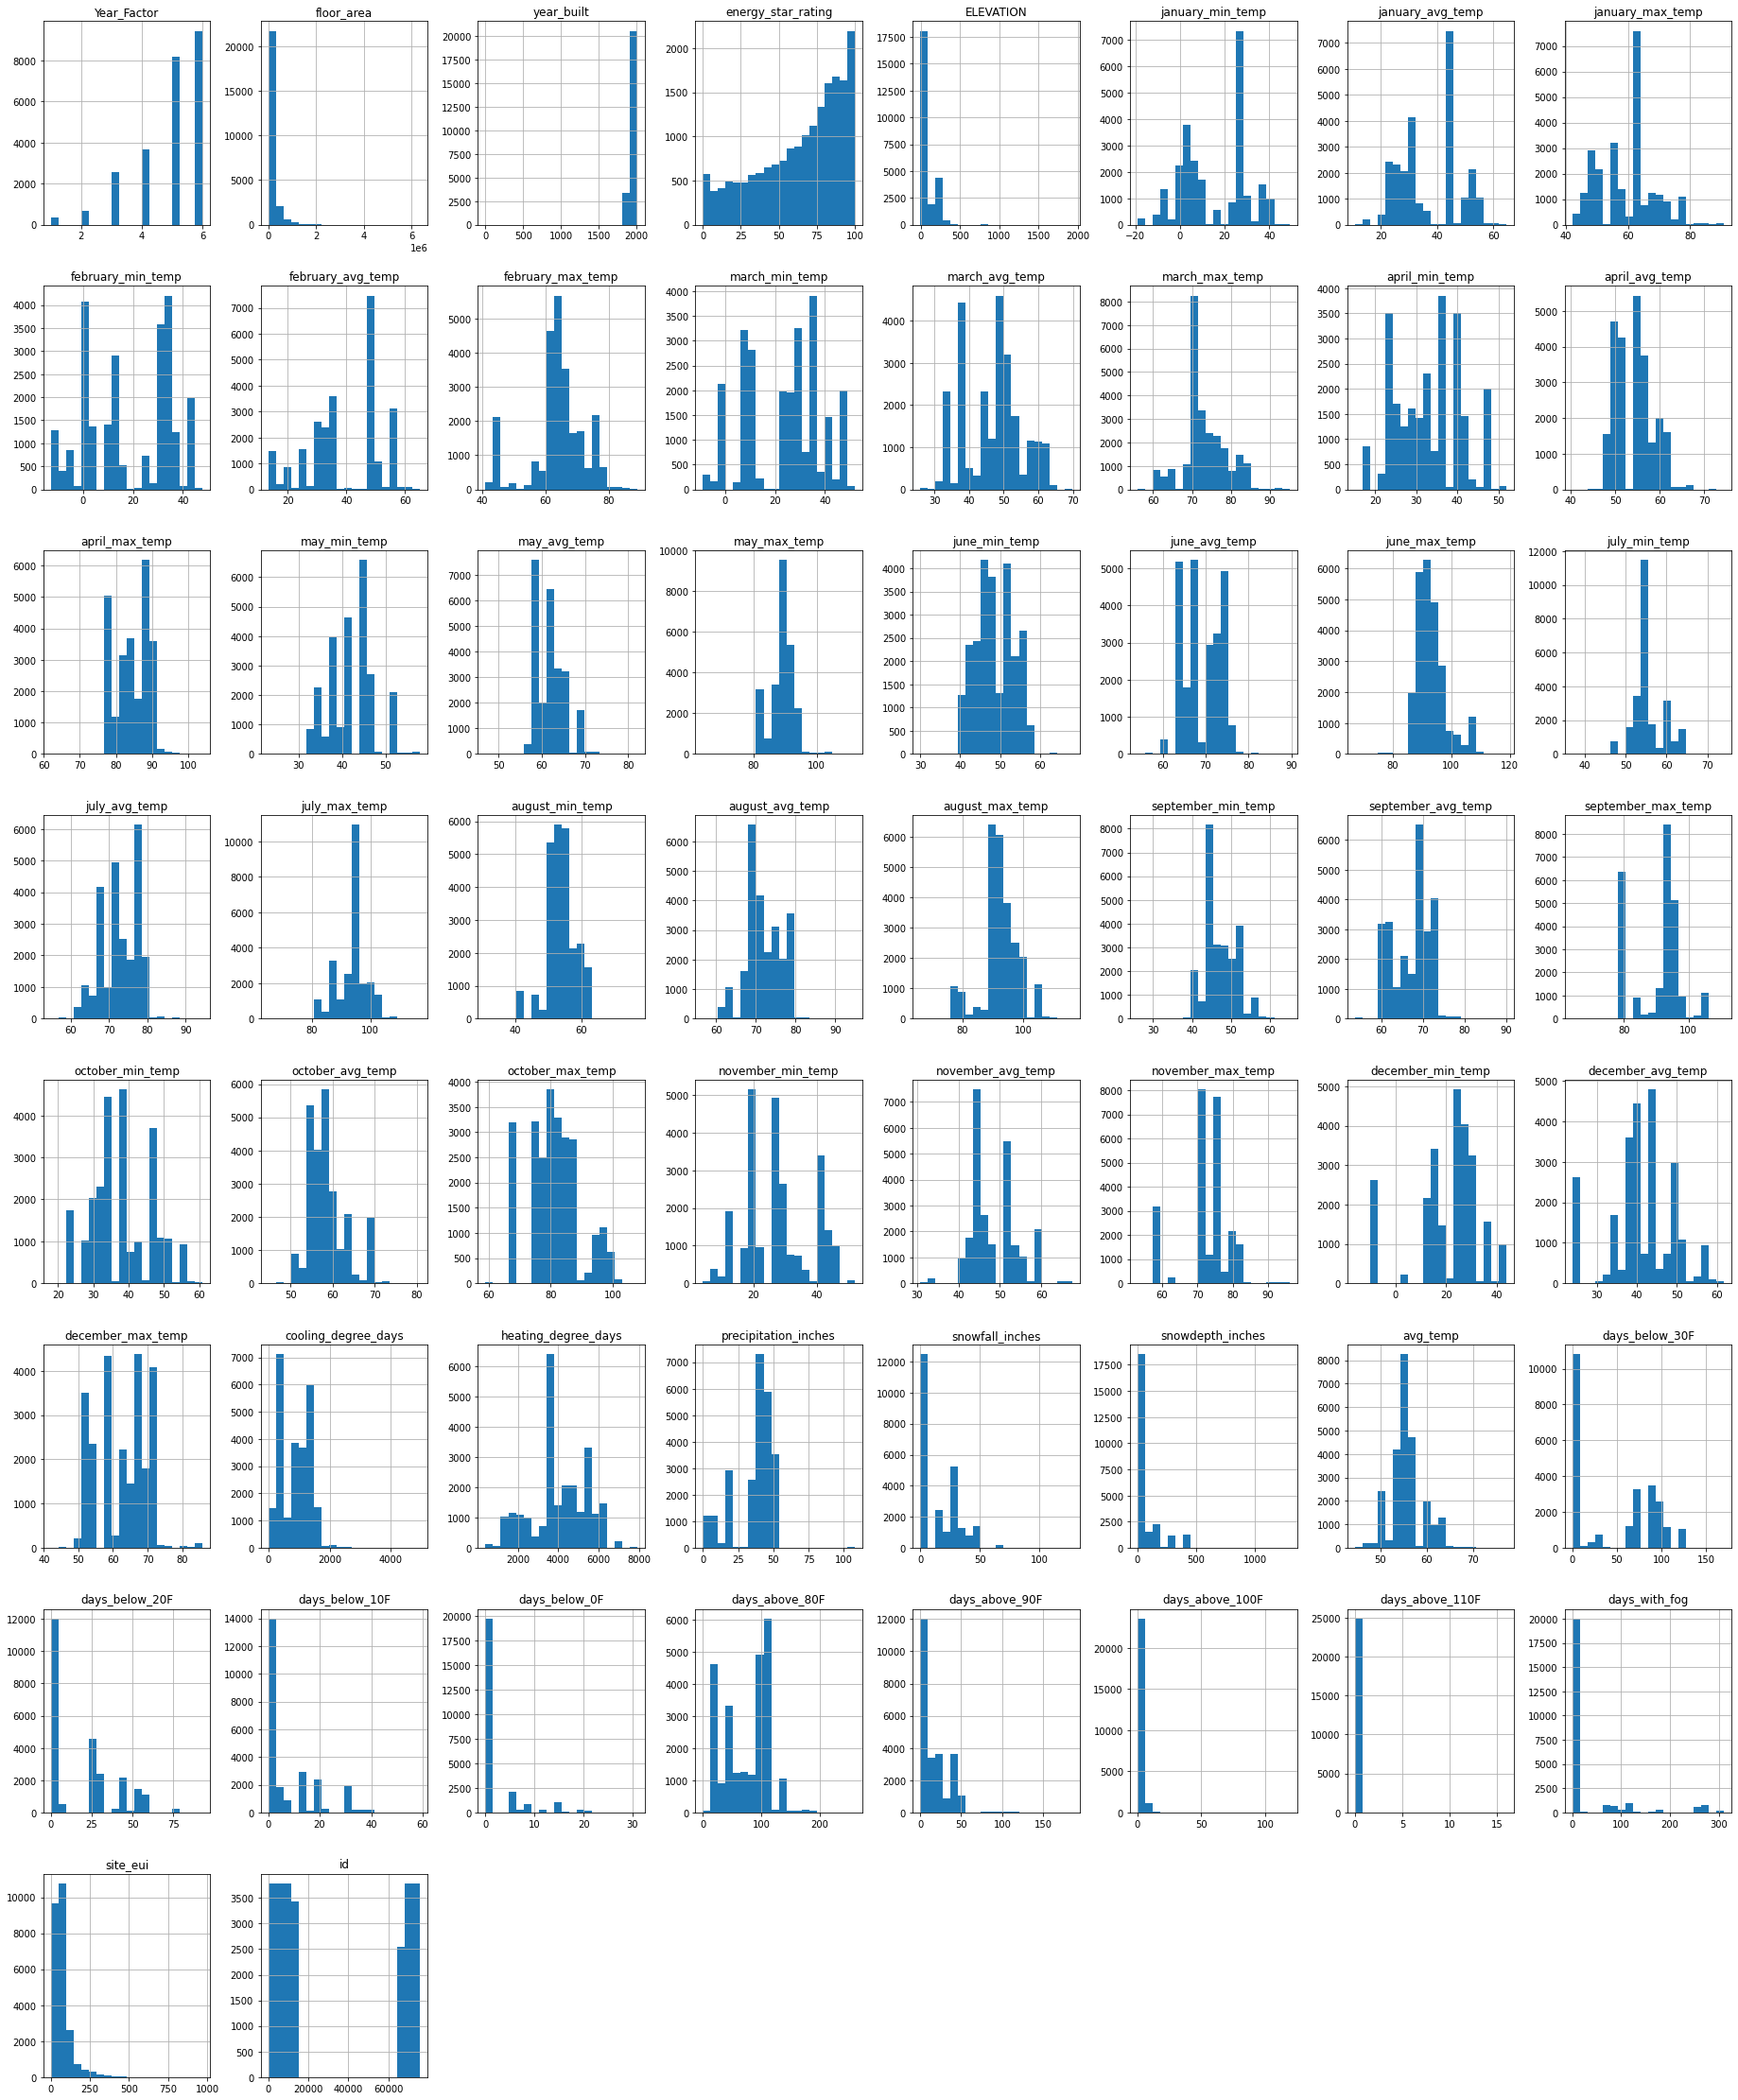

In [59]:
# distribuição das variáveis
_ = df.hist(figsize=[32,40], bins=20)

In [60]:
# somatoria de valores nulos
df.isnull().sum()

Year_Factor        0
State_Factor       0
building_class     0
facility_type      0
floor_area         0
                  ..
days_above_100F    0
days_above_110F    0
days_with_fog      0
site_eui           0
id                 0
Length: 61, dtype: int64

In [61]:
# somente valores nulos
df_null = pd.DataFrame(df.isnull().sum(), columns=['qtd_nulos']).reset_index()
df_null.loc[df_null['qtd_nulos']>0, :]

,index,qtd_nulos
5,year_built,1004
6,energy_star_rating,6556


In [62]:
indices = df_null.loc[df_null['qtd_nulos']>0, :]['index'].values
df[indices].head()

,year_built,energy_star_rating
0,1942.0,11.0
1,1955.0,45.0
2,1951.0,97.0
3,1980.0,46.0
4,1985.0,100.0


In [63]:
# considerando NaN dias sem neblina
df.loc[df['days_with_fog'].isnull(), 'days_with_fog']=0

# pela quantidade de Nan > 50% das amostras
df.drop(columns=['direction_max_wind_speed','direction_peak_wind_speed','max_wind_speed'], inplace=True, errors="ignore")

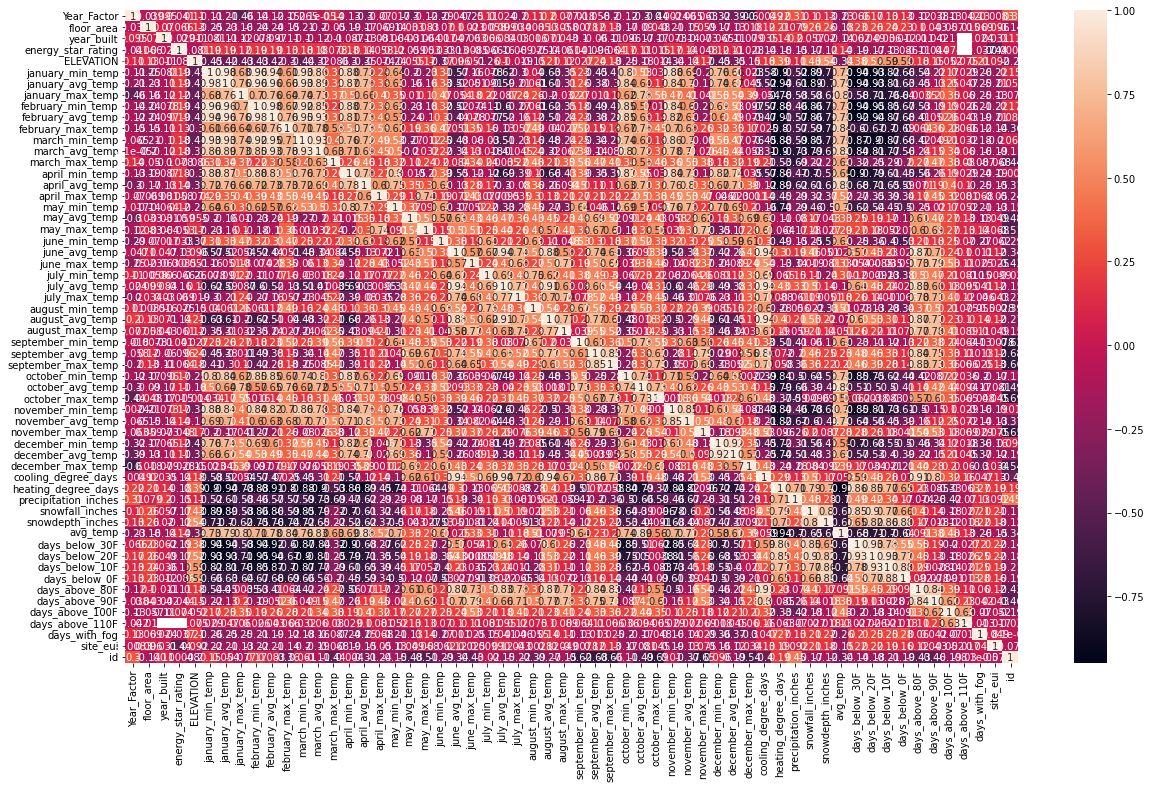

In [64]:
import seaborn as sns 
import matplotlib.pyplot as plt
# Calculando a matriz de variâncias e covariâncias
corr = df.corr(method = 'pearson')
f, ax = plt.subplots(figsize=(20, 12))

# Plotando o heatmap com a biblioteca seaborn
ax = sns.heatmap(corr, annot = True)

In [65]:
# as 5 variáveis mais correlacionadas com a variável target
top = corr['site_eui'].abs().sort_values(ascending=False).head(10)
top = top.sort_values()
top

march_min_temp        0.196271
february_avg_temp     0.211915
january_avg_temp      0.212078
snowfall_inches       0.214979
february_min_temp     0.216764
days_below_30F        0.219531
days_below_20F        0.220948
january_min_temp      0.221666
energy_star_rating    0.442021
site_eui              1.000000
Name: site_eui, dtype: float64

# Encoder e Normalização

In [66]:
# define vetor com os nomes das variaveis numericas e categoricas
var_categoricos = ['State_Factor','building_class','facility_type']
var_numericos = list(set(df.columns.values) - set(var_categoricos))

# remove identificador da construção
var_numericos.remove('id')

# remove variável alvo
var_numericos.remove('site_eui')

In [67]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer


# cria os pipelines
pip_numerico = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

pip_categorico = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ord', OrdinalEncoder()),
    ('scaler', StandardScaler())])

# define as transformacoes no dados
transformacao = ColumnTransformer(
    transformers=[
        ('transformacao numerica', pip_numerico, var_numericos),
        ('transformacao categorica', pip_categorico, var_categoricos),        
    ])

# aplica as transformacoes
dados_transformados = transformacao.fit_transform(df[var_categoricos + var_numericos])

# matrix esparça para densa
#dados_transformados = dados_transformados.todense()
dados_transformados_com_classe = np.c_[dados_transformados, df['site_eui']]
dados_transformados_com_classe.round(2)

array([[ 1.0100e+00, -4.3000e-01, -1.1500e+00, ..., -6.6000e-01,
        -6.8000e-01,  2.4868e+02],
       [ 1.0100e+00, -2.6000e-01, -1.1500e+00, ..., -6.6000e-01,
         1.6900e+00,  2.6500e+01],
       [ 1.0100e+00, -2.6000e-01, -1.1500e+00, ..., -6.6000e-01,
         1.3500e+00,  2.4690e+01],
       ...,
       [ 1.2000e-01, -4.3000e-01, -2.4000e+00, ..., -6.6000e-01,
        -1.3600e+00,  4.8400e+01],
       [ 1.2000e-01, -4.3000e-01, -2.4000e+00, ..., -6.6000e-01,
        -1.3600e+00,  5.9202e+02],
       [ 3.8000e-01, -4.3000e-01, -2.1500e+00, ...,  1.5200e+00,
        -1.7000e+00,  2.9150e+01]])

In [68]:
# retornando a descrição dos atributos
nomes = []
nomes = nomes + var_numericos + var_categoricos
nomes.append("site_eui")

dataframe_processado = pd.DataFrame(data = dados_transformados_com_classe, columns=nomes)
dataframe_processado.head()

,april_min_temp,days_with_fog,may_max_temp,days_above_100F,october_max_temp,january_max_temp,february_avg_temp,august_max_temp,days_below_10F,february_max_temp,floor_area,april_max_temp,september_max_temp,year_built,april_avg_temp,june_avg_temp,august_min_temp,december_min_temp,june_max_temp,heating_degree_days,days_below_0F,march_avg_temp,days_above_90F,march_max_temp,september_min_temp,december_max_temp,days_above_110F,january_min_temp,july_max_temp,Year_Factor,july_min_temp,march_min_temp,november_min_temp,snowdepth_inches,november_avg_temp,february_min_temp,days_below_30F,energy_star_rating,september_avg_temp,july_avg_temp,november_max_temp,avg_temp,october_min_temp,october_avg_temp,january_avg_temp,cooling_degree_days,snowfall_inches,june_min_temp,precipitation_inches,may_avg_temp,august_avg_temp,ELEVATION,days_above_80F,december_avg_temp,may_min_temp,days_below_20F,State_Factor,building_class,facility_type,site_eui
0,1.014442,-0.425846,-1.147492,-0.201466,0.228018,0.973797,0.919358,-1.147361,-0.695492,1.096149,-0.388881,-1.389654,-0.058421,-0.385316,0.295295,-1.999424,-0.336286,1.259444,-0.683591,-0.849418,-0.449793,0.863937,-0.973045,1.198226,1.146492,1.131511,-0.029966,1.360875,-1.862604,-3.26222,-0.970917,1.127924,1.536565,-0.58631,0.998553,0.99043,-1.150416,-2.214030,-0.570618,-1.977231,-0.109099,0.326456,1.097724,1.018425,1.235597,-1.51747,-0.911542,0.267825,-1.484161,-1.632553,-2.2545,-0.720984,-1.584802,1.062337,0.794954,-0.901171,-1.504288,-0.658528,-0.679321,248.682615
1,1.014442,-0.258659,-1.147492,-0.201466,0.228018,0.973797,0.919358,-1.147361,-0.695492,1.096149,0.380833,-1.389654,-0.058421,-0.102593,0.295295,-1.999424,-0.336286,1.259444,-0.683591,-0.849418,-0.449793,0.863937,-0.973045,1.198226,1.146492,1.131511,-0.029966,1.360875,-1.862604,-3.26222,-0.970917,1.127924,1.536565,-0.58631,0.998553,0.99043,-1.150416,-0.796824,-0.570618,-1.977231,-0.109099,0.326456,1.097724,1.018425,1.235597,-1.51747,-0.911542,0.267825,-1.484161,-1.632553,-2.2545,-0.727256,-1.584802,1.062337,0.794954,-0.901171,-1.504288,-0.658528,1.692899,26.500150
2,1.014442,-0.258659,-1.147492,-0.201466,0.228018,0.973797,0.919358,-1.147361,-0.695492,1.096149,0.402630,-1.389654,-0.058421,-0.189584,0.295295,-1.999424,-0.336286,1.259444,-0.683591,-0.849418,-0.449793,0.863937,-0.973045,1.198226,1.146492,1.131511,-0.029966,1.360875,-1.862604,-3.26222,-0.970917,1.127924,1.536565,-0.58631,0.998553,0.99043,-1.150416,1.370668,-0.570618,-1.977231,-0.109099,0.326456,1.097724,1.018425,1.235597,-1.51747,-0.911542,0.267825,-1.484161,-1.632553,-2.2545,-0.727256,-1.584802,1.062337,0.794954,-0.901171,-1.504288,-0.658528,1.354010,24.693619
3,1.014442,-0.258659,-1.147492,-0.201466,0.228018,0.973797,0.919358,-1.147361,-0.695492,1.096149,-0.410288,-1.389654,-0.058421,0.441106,0.295295,-1.999424,-0.336286,1.259444,-0.683591,-0.849418,-0.449793,0.863937,-0.973045,1.198226,1.146492,1.131511,-0.029966,1.360875,-1.862604,-3.26222,-0.970917,1.127924,1.536565,-0.58631,0.998553,0.99043,-1.150416,-0.755141,-0.570618,-1.977231,-0.109099,0.326456,1.097724,1.018425,1.235597,-1.51747,-0.911542,0.267825,-1.484161,-1.632553,-2.2545,-0.727256,-1.584802,1.062337,0.794954,-0.901171,-1.504288,-0.658528,-1.018209,48.406926
4,1.014442,-0.425846,-1.147492,-0.201466,0.228018,0.973797,0.919358,-1.147361,-0.695492,1.096149,-0.371668,-1.389654,-0.058421,0.549845,0.295295,-1.999424,-0.336286,1.259444,-0.683591,-0.849418,-0.449793,0.863937,-0.973045,1.198226,1.146492,1.131511,-0.029966,1.360875,-1.862604,-3.26222,-0.970917,1.127924,1.536565,-0.58631,0.998553,0.99043,-1.150416,1.495715,-0.570618,-1.977231,-0.109099,0.326456,1.097724,1.018425,1.235597,-1.51747,-0.911542,0.267825,-1.484161,-1.632553,-2.2545,-0.720984,-1.584802,1.062337,0.794954,-0.901171,-1.504288,-0.658528,1.692899,3.899395


# Seleção de variáveis

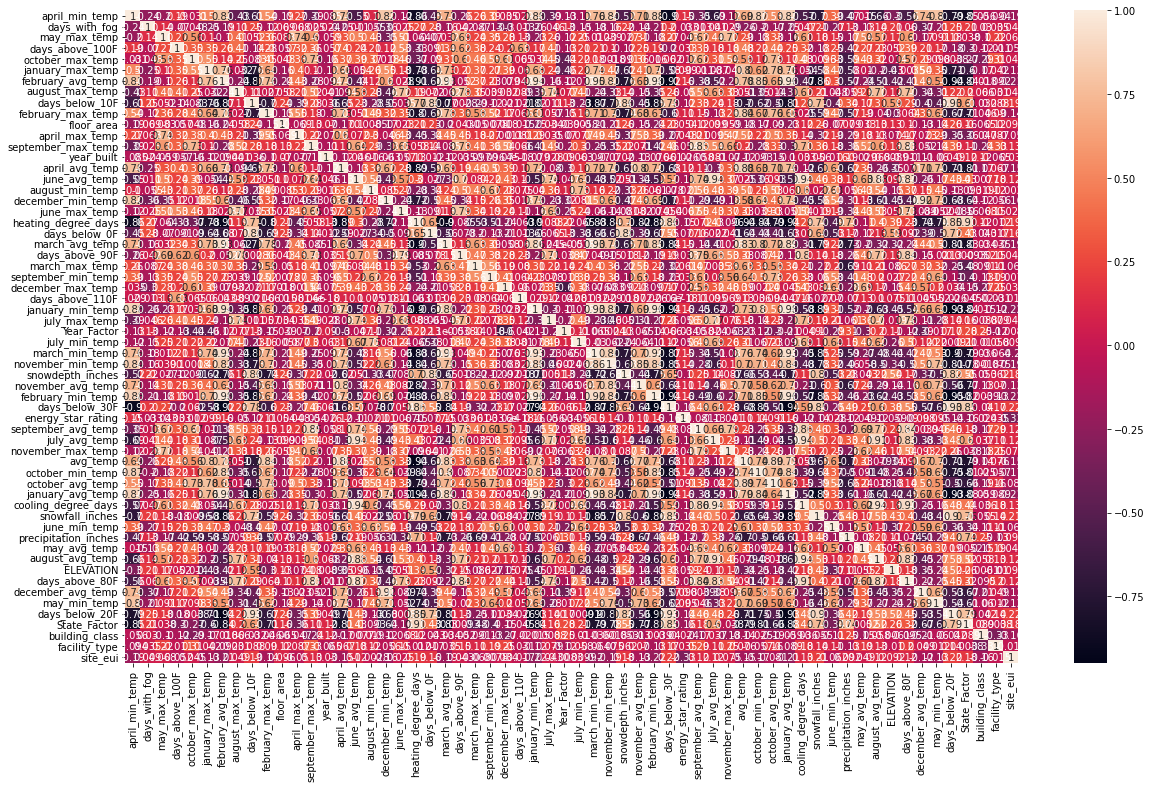

In [69]:
import seaborn as sns 
import matplotlib.pyplot as plt
# Calculando a matriz de variâncias e covariâncias
corr = dataframe_processado.corr(method = 'pearson')
f, ax = plt.subplots(figsize=(20, 12))

# Plotando o heatmap com a biblioteca seaborn
ax = sns.heatmap(corr, annot = True)

In [70]:
# as 5 variáveis mais correlacionadas com a variável target
top = corr['site_eui'].abs().sort_values(ascending=False).head(20)
top = top.sort_values()
top

building_class         0.161112
days_below_0F          0.164094
october_min_temp       0.169691
State_Factor           0.181132
snowdepth_inches       0.183590
march_avg_temp         0.186908
heating_degree_days    0.189908
april_min_temp         0.189949
november_min_temp      0.191232
days_below_10F         0.193825
march_min_temp         0.196271
february_avg_temp      0.211915
january_avg_temp       0.212078
snowfall_inches        0.214979
february_min_temp      0.216764
days_below_30F         0.219531
days_below_20F         0.220948
january_min_temp       0.221666
energy_star_rating     0.325963
site_eui               1.000000
Name: site_eui, dtype: float64

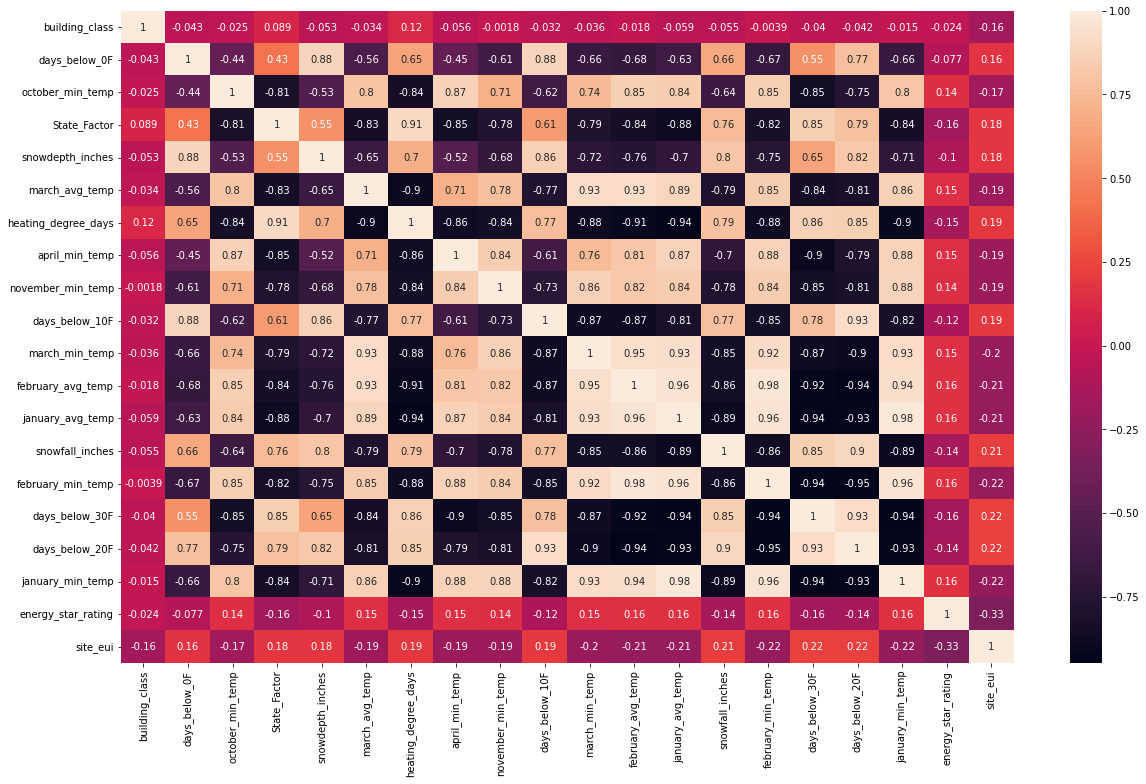

In [71]:
# Calculando a matriz de variâncias e covariâncias
corr = dataframe_processado[top.index].corr(method = 'pearson')
f, ax = plt.subplots(figsize=(20, 12))

# Plotando o heatmap com a biblioteca seaborn
ax = sns.heatmap(corr, annot = True)

In [72]:
dataframe_processado.head()

,april_min_temp,days_with_fog,may_max_temp,days_above_100F,october_max_temp,january_max_temp,february_avg_temp,august_max_temp,days_below_10F,february_max_temp,floor_area,april_max_temp,september_max_temp,year_built,april_avg_temp,june_avg_temp,august_min_temp,december_min_temp,june_max_temp,heating_degree_days,days_below_0F,march_avg_temp,days_above_90F,march_max_temp,september_min_temp,december_max_temp,days_above_110F,january_min_temp,july_max_temp,Year_Factor,july_min_temp,march_min_temp,november_min_temp,snowdepth_inches,november_avg_temp,february_min_temp,days_below_30F,energy_star_rating,september_avg_temp,july_avg_temp,november_max_temp,avg_temp,october_min_temp,october_avg_temp,january_avg_temp,cooling_degree_days,snowfall_inches,june_min_temp,precipitation_inches,may_avg_temp,august_avg_temp,ELEVATION,days_above_80F,december_avg_temp,may_min_temp,days_below_20F,State_Factor,building_class,facility_type,site_eui
0,1.014442,-0.425846,-1.147492,-0.201466,0.228018,0.973797,0.919358,-1.147361,-0.695492,1.096149,-0.388881,-1.389654,-0.058421,-0.385316,0.295295,-1.999424,-0.336286,1.259444,-0.683591,-0.849418,-0.449793,0.863937,-0.973045,1.198226,1.146492,1.131511,-0.029966,1.360875,-1.862604,-3.26222,-0.970917,1.127924,1.536565,-0.58631,0.998553,0.99043,-1.150416,-2.214030,-0.570618,-1.977231,-0.109099,0.326456,1.097724,1.018425,1.235597,-1.51747,-0.911542,0.267825,-1.484161,-1.632553,-2.2545,-0.720984,-1.584802,1.062337,0.794954,-0.901171,-1.504288,-0.658528,-0.679321,248.682615
1,1.014442,-0.258659,-1.147492,-0.201466,0.228018,0.973797,0.919358,-1.147361,-0.695492,1.096149,0.380833,-1.389654,-0.058421,-0.102593,0.295295,-1.999424,-0.336286,1.259444,-0.683591,-0.849418,-0.449793,0.863937,-0.973045,1.198226,1.146492,1.131511,-0.029966,1.360875,-1.862604,-3.26222,-0.970917,1.127924,1.536565,-0.58631,0.998553,0.99043,-1.150416,-0.796824,-0.570618,-1.977231,-0.109099,0.326456,1.097724,1.018425,1.235597,-1.51747,-0.911542,0.267825,-1.484161,-1.632553,-2.2545,-0.727256,-1.584802,1.062337,0.794954,-0.901171,-1.504288,-0.658528,1.692899,26.500150
2,1.014442,-0.258659,-1.147492,-0.201466,0.228018,0.973797,0.919358,-1.147361,-0.695492,1.096149,0.402630,-1.389654,-0.058421,-0.189584,0.295295,-1.999424,-0.336286,1.259444,-0.683591,-0.849418,-0.449793,0.863937,-0.973045,1.198226,1.146492,1.131511,-0.029966,1.360875,-1.862604,-3.26222,-0.970917,1.127924,1.536565,-0.58631,0.998553,0.99043,-1.150416,1.370668,-0.570618,-1.977231,-0.109099,0.326456,1.097724,1.018425,1.235597,-1.51747,-0.911542,0.267825,-1.484161,-1.632553,-2.2545,-0.727256,-1.584802,1.062337,0.794954,-0.901171,-1.504288,-0.658528,1.354010,24.693619
3,1.014442,-0.258659,-1.147492,-0.201466,0.228018,0.973797,0.919358,-1.147361,-0.695492,1.096149,-0.410288,-1.389654,-0.058421,0.441106,0.295295,-1.999424,-0.336286,1.259444,-0.683591,-0.849418,-0.449793,0.863937,-0.973045,1.198226,1.146492,1.131511,-0.029966,1.360875,-1.862604,-3.26222,-0.970917,1.127924,1.536565,-0.58631,0.998553,0.99043,-1.150416,-0.755141,-0.570618,-1.977231,-0.109099,0.326456,1.097724,1.018425,1.235597,-1.51747,-0.911542,0.267825,-1.484161,-1.632553,-2.2545,-0.727256,-1.584802,1.062337,0.794954,-0.901171,-1.504288,-0.658528,-1.018209,48.406926
4,1.014442,-0.425846,-1.147492,-0.201466,0.228018,0.973797,0.919358,-1.147361,-0.695492,1.096149,-0.371668,-1.389654,-0.058421,0.549845,0.295295,-1.999424,-0.336286,1.259444,-0.683591,-0.849418,-0.449793,0.863937,-0.973045,1.198226,1.146492,1.131511,-0.029966,1.360875,-1.862604,-3.26222,-0.970917,1.127924,1.536565,-0.58631,0.998553,0.99043,-1.150416,1.495715,-0.570618,-1.977231,-0.109099,0.326456,1.097724,1.018425,1.235597,-1.51747,-0.911542,0.267825,-1.484161,-1.632553,-2.2545,-0.720984,-1.584802,1.062337,0.794954,-0.901171,-1.504288,-0.658528,1.692899,3.899395


In [73]:
labels = ['facility_type','building_class','State_Factor','energy_star_rating','ELEVATION','floor_area','avg_temp','days_with_fog','cooling_degree_days']

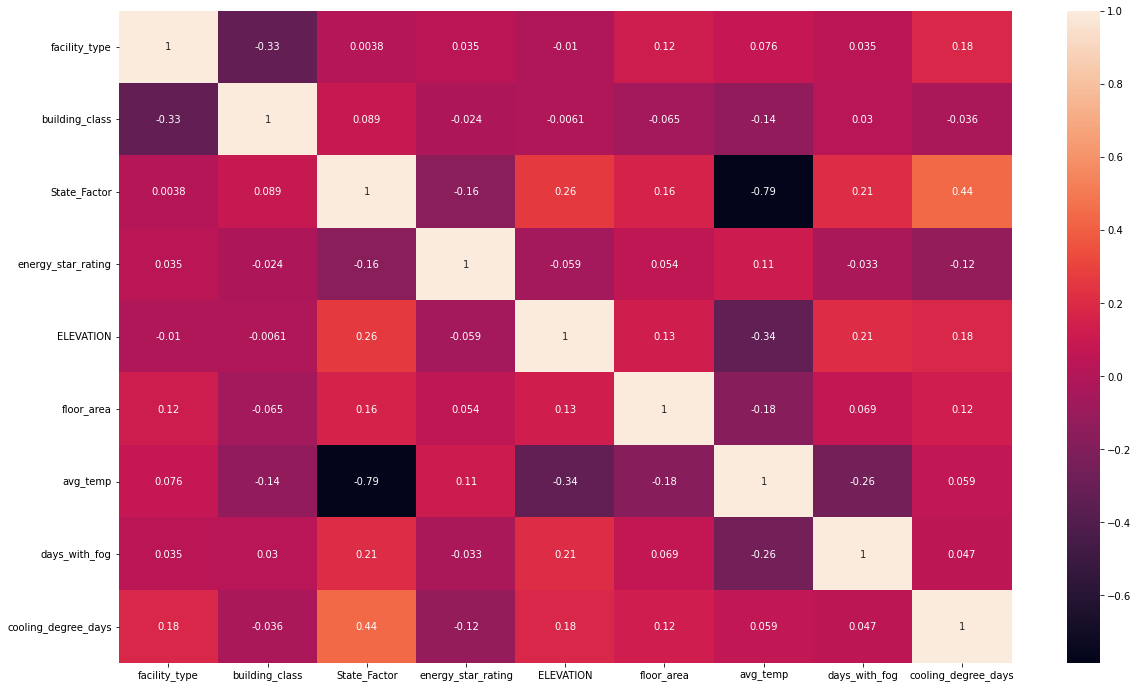

In [74]:
# Calculando a matriz de variâncias e covariâncias
corr = dataframe_processado[labels].corr(method = 'pearson')
f, ax = plt.subplots(figsize=(20, 12))

# Plotando o heatmap com a biblioteca seaborn
ax = sns.heatmap(corr, annot = True)

# Classificação

## Regresão linear com transformação

In [75]:
from sklearn.preprocessing import PolynomialFeatures

X = dataframe_processado[labels].to_numpy()
y = dataframe_processado['site_eui'].to_numpy()

# Utilizando um polinomio de grau 2
p = PolynomialFeatures(degree=1)

X_Transf = p.fit_transform(X)
print(p.get_feature_names_out())
print(X_Transf)

['1' 'x0' 'x1' 'x2' 'x3' 'x4' 'x5' 'x6' 'x7' 'x8']
[[ 1.         -0.67932064 -0.65852819 ...  0.32645624 -0.42584605
  -1.51747041]
 [ 1.          1.69289872 -0.65852819 ...  0.32645624 -0.25865942
  -1.51747041]
 [ 1.          1.35401024 -0.65852819 ...  0.32645624 -0.25865942
  -1.51747041]
 ...
 [ 1.         -1.3570976  -0.65852819 ... -2.217433   -0.42584605
  -1.63826301]
 [ 1.         -1.3570976  -0.65852819 ... -2.217433   -0.42584605
  -1.63826301]
 [ 1.         -1.69598608  1.51853787 ... -1.87599952 -0.42584605
  -1.45103448]]


In [76]:
from sklearn.linear_model import LinearRegression

# Note que nesse caso colocamos fit_intercept = False pois já capturamos o 
# termo idependente ao fazermos a transformação anterior
lin = LinearRegression(fit_intercept=False)
lin.fit(X_Transf, y)

#print(lin.coef_.round(2))
print(lin.score(X_Transf, y))

0.17455428031469833


In [77]:
lin.predict(X_Transf).mean()

72.59437043004155

In [78]:
y.mean()

72.59437043004154

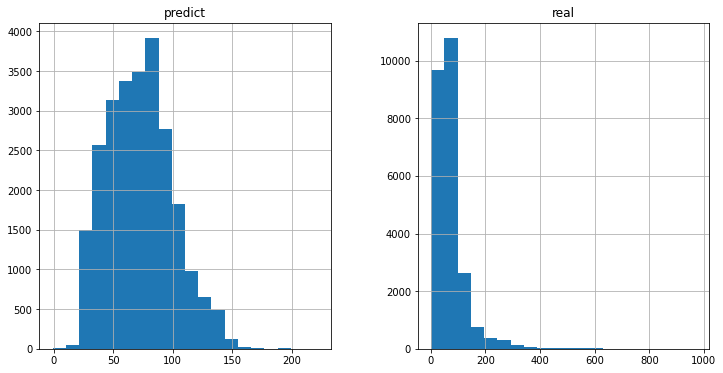

In [79]:
_ = pd.DataFrame(list(zip(lin.predict(X_Transf), y)), columns=['predict','real']).hist(figsize=[12,6], bins=20)

# Submissão

In [80]:
import pandas as pd
df_sub = pd.read_csv('test.csv.zip')
df_sub.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,id
0,7,State_1,Commercial,Grocery_store_or_food_market,28484.0,1994.0,37.0,2.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75757
1,7,State_1,Commercial,Grocery_store_or_food_market,21906.0,1961.0,55.0,45.7,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75758
2,7,State_1,Commercial,Grocery_store_or_food_market,16138.0,1950.0,1.0,59.1,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75759
3,7,State_1,Commercial,Grocery_store_or_food_market,97422.0,1971.0,34.0,35.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75760
4,7,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,35.0,1.8,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,340.0,330.0,22.8,126.0,75761


In [81]:
df['State_Factor'].value_counts()

State_11    6412
State_1     5618
State_2     4871
State_4     4300
State_8     3701
State_10      15
Name: State_Factor, dtype: int64

In [82]:
df_sub['State_Factor'].value_counts()

State_11    3268
State_4     2568
State_2     1515
State_8     1323
State_1     1027
State_10       4
Name: State_Factor, dtype: int64

In [83]:
df['State_Factor'].value_counts().index

Index(['State_11', 'State_1', 'State_2', 'State_4', 'State_8', 'State_10'], dtype='object')

In [84]:
df['building_class'].value_counts()

Commercial     17380
Residential     7537
Name: building_class, dtype: int64

In [85]:
df_sub['building_class'].value_counts()

Commercial     5607
Residential    4098
Name: building_class, dtype: int64

In [86]:
df['facility_type'].value_counts()

Office         6692
Multifamily    3688
Education      3676
2to4           1893
Lodging        1404
Warehouse      1398
5plus          1273
Commercial      953
Retail          938
Mixed           683
Public          487
Grocery         361
Religious       322
Nursing         246
Health          244
Industrial      196
Food            136
Service         108
Parking         106
Laboratory      101
Data             12
Name: facility_type, dtype: int64

In [87]:
df_sub['facility_type'] = df_sub['facility_type'].apply(lambda x: x.split('_')[0])
df_sub['facility_type'].value_counts()

Multifamily    2199
Office         2046
Education      1107
2to4            966
5plus           685
Lodging         479
Warehouse       462
Commercial      348
Retail          307
Mixed           248
Public          159
Nursing         151
Grocery         135
Religious       125
Health           87
Industrial       47
Laboratory       44
Food             43
Parking          37
Service          26
Data              4
Name: facility_type, dtype: int64

In [88]:
df_sub['Year_Factor'].value_counts() # nao vamos usar, nao esta em labels

7    9705
Name: Year_Factor, dtype: int64

In [89]:
df_sub['year_built'].value_counts() # nao vamos usar, nao esta em labels

2000.0    176
1970.0    157
1925.0    154
1968.0    154
2008.0    152
         ... 
1844.0      1
1873.0      1
1879.0      1
1869.0      1
1840.0      1
Name: year_built, Length: 164, dtype: int64

In [90]:
df_sub[labels].isnull().sum()

facility_type             0
building_class            0
State_Factor              0
energy_star_rating     2254
ELEVATION                 0
floor_area                0
avg_temp                  0
days_with_fog          9117
cooling_degree_days       0
dtype: int64

In [91]:
# considerando NaN dias sem neblina
df_sub.loc[df_sub['days_with_fog'].isnull(), 'days_with_fog']=0

In [92]:
# aplica as mesmas transformacoes nos dados de submissao
dados_transformados = transformacao.fit_transform(df_sub[var_categoricos + var_numericos])

# matrix esparça para densa
#dados_transformados = dados_transformados.todense()
dados_transformados_com_classe = np.c_[dados_transformados]
dados_transformados_com_classe.round(2)

# retornando a descrição dos atributos
nomes = []
nomes = nomes + var_numericos + var_categoricos

dataframe_processado = pd.DataFrame(data = dados_transformados_com_classe, columns=nomes)
dataframe_processado.head()

,april_min_temp,days_with_fog,may_max_temp,days_above_100F,october_max_temp,january_max_temp,february_avg_temp,august_max_temp,days_below_10F,february_max_temp,floor_area,april_max_temp,september_max_temp,year_built,april_avg_temp,june_avg_temp,august_min_temp,december_min_temp,june_max_temp,heating_degree_days,days_below_0F,march_avg_temp,days_above_90F,march_max_temp,september_min_temp,december_max_temp,days_above_110F,january_min_temp,july_max_temp,Year_Factor,july_min_temp,march_min_temp,november_min_temp,snowdepth_inches,november_avg_temp,february_min_temp,days_below_30F,energy_star_rating,september_avg_temp,july_avg_temp,november_max_temp,avg_temp,october_min_temp,october_avg_temp,january_avg_temp,cooling_degree_days,snowfall_inches,june_min_temp,precipitation_inches,may_avg_temp,august_avg_temp,ELEVATION,days_above_80F,december_avg_temp,may_min_temp,days_below_20F,State_Factor,building_class,facility_type
0,1.906157,-0.235647,-0.080714,2.906863,1.624204,0.679483,2.323864,-1.401998,-0.804544,-0.147081,-0.513332,-0.042726,2.565423,0.757692,1.018998,-0.901948,0.186769,1.45149,1.747362,-2.104886,-0.599846,2.114588,-0.530789,0.62324,1.552901,1.266556,0.0,1.964985,-0.858626,0.0,-0.021704,1.631945,2.097808,-0.525195,2.117366,1.871769,-1.283931,-1.132239,1.209536,-1.330919,0.290288,1.639641,2.544421,1.635641,1.99747,-0.865568,-0.92396,1.4308,-2.324975,0.634639,-1.491969,-0.765952,-1.222555,1.950412,1.725789,-0.881922,-1.995206,-0.854911,-0.608289
1,1.906157,-0.235647,-0.080714,2.906863,1.624204,0.679483,2.323864,-1.401998,-0.804544,-0.147081,-0.538395,-0.042726,2.565423,-0.054638,1.018998,-0.901948,0.186769,1.45149,1.747362,-2.104886,-0.599846,2.114588,-0.530789,0.62324,1.552901,1.266556,0.0,1.964985,-0.858626,0.0,-0.021704,1.631945,2.097808,-0.525195,2.117366,1.871769,-1.283931,-0.396831,1.209536,-1.330919,0.290288,1.639641,2.544421,1.635641,1.99747,-0.865568,-0.92396,1.4308,-2.324975,0.634639,-1.491969,-0.602438,-1.222555,1.950412,1.725789,-0.881922,-1.995206,-0.854911,-0.608289
2,1.906157,-0.235647,-0.080714,2.906863,1.624204,0.679483,2.323864,-1.401998,-0.804544,-0.147081,-0.560371,-0.042726,2.565423,-0.325414,1.018998,-0.901948,0.186769,1.45149,1.747362,-2.104886,-0.599846,2.114588,-0.530789,0.62324,1.552901,1.266556,0.0,1.964985,-0.858626,0.0,-0.021704,1.631945,2.097808,-0.525195,2.117366,1.871769,-1.283931,-2.603054,1.209536,-1.330919,0.290288,1.639641,2.544421,1.635641,1.99747,-0.865568,-0.92396,1.4308,-2.324975,0.634639,-1.491969,-0.551836,-1.222555,1.950412,1.725789,-0.881922,-1.995206,-0.854911,-0.608289
3,1.906157,-0.235647,-0.080714,2.906863,1.624204,0.679483,2.323864,-1.401998,-0.804544,-0.147081,-0.250673,-0.042726,2.565423,0.191523,1.018998,-0.901948,0.186769,1.45149,1.747362,-2.104886,-0.599846,2.114588,-0.530789,0.62324,1.552901,1.266556,0.0,1.964985,-0.858626,0.0,-0.021704,1.631945,2.097808,-0.525195,2.117366,1.871769,-1.283931,-1.254807,1.209536,-1.330919,0.290288,1.639641,2.544421,1.635641,1.99747,-0.865568,-0.92396,1.4308,-2.324975,0.634639,-1.491969,-0.641334,-1.222555,1.950412,1.725789,-0.881922,-1.995206,-0.854911,-0.608289
4,1.906157,3.015072,-0.080714,2.906863,1.624204,0.679483,2.323864,-1.401998,-0.804544,-0.147081,-0.388522,-0.042726,2.565423,-0.522343,1.018998,-0.901948,0.186769,1.45149,1.747362,-2.104886,-0.599846,2.114588,-0.530789,0.62324,1.552901,1.266556,0.0,1.964985,-0.858626,0.0,-0.021704,1.631945,2.097808,-0.525195,2.117366,1.871769,-1.283931,-1.213951,1.209536,-1.330919,0.290288,1.639641,2.544421,1.635641,1.99747,-0.865568,-0.92396,1.4308,-2.324975,0.634639,-1.491969,-0.768218,-1.222555,1.950412,1.725789,-0.881922,-1.995206,-0.854911,-0.608289


In [93]:
# regr.fit(X, y)

X = dataframe_processado[labels].to_numpy()
id = df_sub['id'].to_numpy()

#y_pred = regr.predict(X)
#y_pred = rs.best_estimator_.predict(X)

X_Transf = p.fit_transform(X)
y_pred = lin.predict(X_Transf)

# não existe gasto negativo
y_pred[y_pred<0]=0

In [94]:
y.mean()

72.59437043004154

In [95]:
y_pred.mean()

72.59437043004156

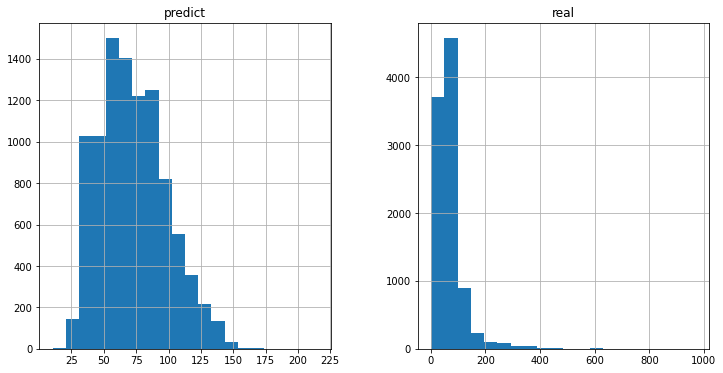

In [96]:
_ = pd.DataFrame(list(zip(lin.predict(X_Transf), y)), columns=['predict','real']).hist(figsize=[12,6], bins=20)

In [97]:
df_submissao = pd.DataFrame(data=np.c_[id, y_pred.round(1)], columns=['id','site_eui'])
df_submissao['id'] = df_submissao['id'].astype(int)
df_submissao.to_csv('submissao.csv',index=False)

In [98]:
!kaggle competitions submit -c widsdatathon2022 -f submissao.csv -m "Linear Regression Poly(degree=1)"

100% 106k/106k [00:02<00:00, 44.7kB/s]
Successfully submitted to WiDS Datathon 2022

# tensorf

In [23]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

In [24]:
X = dataframe_processado.drop(columns=['site_eui']).to_numpy()
y = dataframe_processado['site_eui'].to_numpy()

In [25]:
X.shape

(75757, 59)

In [26]:
model = tf.keras.models.Sequential([tf.keras.layers.Dense(1, activation=tf.nn.relu)])

In [ ]:
model.compile(optimizer='sgd', loss='mean_squared_error')
model.fit(X, y, epochs=100)

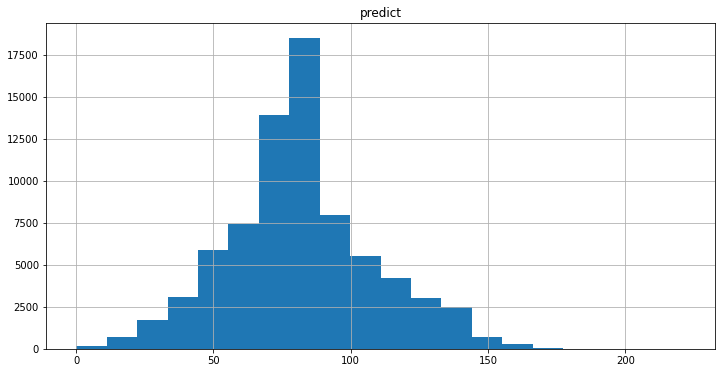

In [30]:
_ = pd.DataFrame(list(model.predict(X)), columns=['predict']).hist(figsize=[12,6], bins=20)

In [31]:
model.predict(X).mean()

81.980774